Joan Carles Montero
# Machine Learning-Based Classification of Skin Lesions
### REMOTE 7-class classification

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
# List the contents of the folder
folder_path = '/content/drive/My Drive/Skin Cancer Lesions Segmentation'
os.listdir(folder_path)

['Skin Cancer- Lesions Segmentation.url',
 '.ipynb_checkpoints',
 'data',
 'images.npy',
 'labels.npy',
 'model',
 'images_mel.npy',
 'labels_mel.npy',
 'model_mel',
 'Skin Cancer segmentation melanoma.ipynb',
 'Skin Cancer segmentation.ipynb',
 'Machine Learning-Based Classification of Skin Lesions.gslides']

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
!export CUDA_VISIBLE_DEVICES=1
!nvidia-smi
gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
session = tf.compat.v1.InteractiveSession(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

Num GPUs Available:  1
Thu Dec  7 11:02:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                 

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
# Paths to the data
metadata_path = os.path.join(folder_path, "data/metadata.csv")
images_path = os.path.join(folder_path, "images.npy")
#images_path = os.path.join(folder_path, "images_filtered.npy")
labels_path = os.path.join(folder_path, "labels.npy")

# Load the data
metadata = pd.read_csv(metadata_path)
images = np.load(images_path, allow_pickle=True)
images_normalized = images.astype(np.float32) / 255.0
labels = np.load(labels_path, allow_pickle=True)
print(images.shape)
print(labels.shape)

# Disordering the data
permuted_indices = np.random.permutation(images.shape[0])

shuffled_images = images[permuted_indices]
shuffled_labels = labels[permuted_indices]

(1001, 225, 300, 3)
(1001, 7)


In [ ]:
class_sums = labels.sum(axis=0)

class_proportions = class_sums / labels.shape[0]
class_proportions

array([0.14285714285714285, 0.14285714285714285, 0.14285714285714285,
       0.14285714285714285, 0.14285714285714285, 0.14285714285714285,
       0.14285714285714285], dtype=object)

In [ ]:
# Split the dataset
y_single_label = np.argmax(labels, axis=1)
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, stratify=y_single_label, random_state=1234)

# Convert and normalize the image data
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

# Convert labels to the correct type if necessary
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = Sequential([
    BatchNormalization(input_shape=(225, 300, 3)),
    Conv2D(16, (5, 5), activation='relu', padding='same'),
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(),

    Flatten(),

    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.25),

    Dense(7, activation='softmax', kernel_regularizer=l2(0.001))
])

# Compile the model
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

train_datagen = ImageDataGenerator(
    width_shift_range=0.1,  # Small horizontal shifts to simulate patient movement
    height_shift_range=0.1,  # Small vertical shifts to simulate patient movement
    zoom_range=0.1,  # Slight zooming in/out
    fill_mode='nearest',  # Fill in missing pixels with the nearest filled value
    horizontal_flip=False,
    vertical_flip=False,
)

# Apply the augmentation to the training dataset
train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=32  # Batch size
)

# Fit the model using the generator
history = model.fit(
    train_generator,
    validation_data=(X_val, y_val),
    epochs=25,  # Number of epochs
    steps_per_epoch=len(X_train) // 32  # Number of steps per epoch, typically the size of X_train divided by batch size
)


Epoch 1/25
25/25 [==============================] - 27s 558ms/step - loss: 2.6439 - accuracy: 0.2050 - val_loss: 3.5395 - val_accuracy: 0.1791
Epoch 2/25
25/25 [==============================] - 14s 553ms/step - loss: 1.9544 - accuracy: 0.3212 - val_loss: 2.3226 - val_accuracy: 0.1642
Epoch 3/25
25/25 [==============================] - 14s 563ms/step - loss: 1.8001 - accuracy: 0.3850 - val_loss: 3.0593 - val_accuracy: 0.1592
Epoch 4/25
25/25 [==============================] - 14s 551ms/step - loss: 1.6871 - accuracy: 0.4375 - val_loss: 2.5099 - val_accuracy: 0.2438
Epoch 5/25
25/25 [==============================] - 14s 539ms/step - loss: 1.6504 - accuracy: 0.4275 - val_loss: 2.9146 - val_accuracy: 0.2488
Epoch 6/25
25/25 [==============================] - 12s 476ms/step - loss: 1.6427 - accuracy: 0.4162 - val_loss: 1.7835 - val_accuracy: 0.3184
Epoch 7/25
25/25 [==============================] - 14s 553ms/step - loss: 1.5866 - accuracy: 0.4462 - val_loss: 2.0043 - val_accuracy: 0.3234

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 225, 300, 3)       12        
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 225, 300, 16)      1216      
                                                                 
 conv2d_1 (Conv2D)           (None, 225, 300, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 150, 16)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 150, 32)      4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 150, 32)      9

In [ ]:
import tensorflow as tf
model_path = os.path.join(folder_path, 'model')
#model.save(model_path)
model = tf.keras.models.load_model(model_path)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Get probability predictions for the validation set
y_pred_probs = model.predict(X_train)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.argmax(y_train, axis=1)

# Print the classification report
print(classification_report(y_true, y_pred))

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

category_names = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
# Confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report)


NameError: ignored

7/7 [==============================] - 1s 90ms/step
              precision    recall  f1-score   support

         MEL       0.41      0.59      0.49        29
          NV       0.59      0.68      0.63        28
         BCC       0.55      0.64      0.59        28
       AKIEC       0.44      0.38      0.41        29
         BKL       0.53      0.28      0.36        29
          DF       0.54      0.45      0.49        29
        VASC       0.81      0.86      0.83        29

    accuracy                           0.55       201
   macro avg       0.55      0.55      0.54       201
weighted avg       0.55      0.55      0.54       201



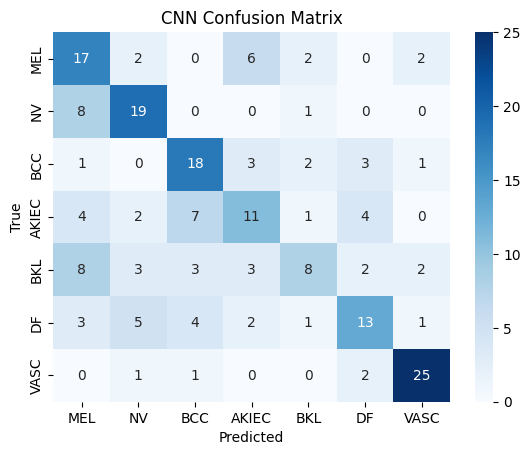

In [ ]:
# Get probability predictions for the validation set
y_pred_probs = model.predict(X_val)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.argmax(y_val, axis=1)

# Print the classification report
print(classification_report(y_true, y_pred,target_names=category_names))

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

category_names = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
# Confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('CNN Confusion Matrix')
plt.savefig('cnn.png')
plt.show()


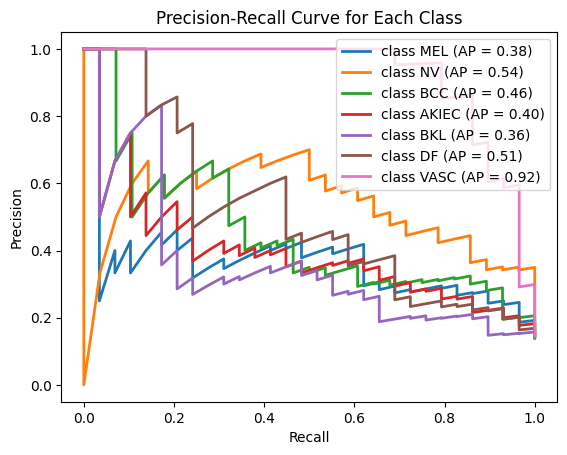

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score, accuracy_score, f1_score, recall_score, precision_score
import numpy as np
import matplotlib.pyplot as plt

num_classes = len(category_names)
# Convert the true labels to one-hot encoding
y_true_one_hot = np.eye(num_classes)[y_true]

# Global metrics
accuracy = accuracy_score(y_true, np.argmax(y_pred_probs, axis=1))
precision = precision_score(y_true, np.argmax(y_pred_probs, axis=1), average='macro')
recall = recall_score(y_true, np.argmax(y_pred_probs, axis=1), average='macro')
f1 = f1_score(y_true, np.argmax(y_pred_probs, axis=1), average='macro')

# PR curve for each class
precision_dict = {}
recall_dict = {}
threshold_dict = {}
average_precision_dict = {}

# For each class
for i in range(num_classes):
    precision_dict[i], recall_dict[i], threshold_dict[i] = precision_recall_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
    average_precision_dict[i] = average_precision_score(y_true_one_hot[:, i], y_pred_probs[:, i])

# Now plot the PR curve for each class

for i, label in enumerate(category_names):
    plt.plot(recall_dict[i], precision_dict[i], lw=2, label=f'class {label} (AP = {average_precision_dict[i]:0.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend(loc='best')
plt.savefig('prs.png')
plt.show()

In [ ]:
desired_recall = 0.9

# Find the closest recall value to your desired recall and its corresponding threshold
closest_recall_idx = np.argmin(np.abs(recall_dict[0] - desired_recall))
selected_threshold = threshold_dict[0][closest_recall_idx]

# Function to make predictions with a specific recall threshold for class 1
def predict_with_threshold(y_pred_probs, threshold):
    y_pred_modified = []
    for prob in y_pred_probs:
        if prob[0] >= threshold:  # If class 1 probability is above threshold, predict class 1
            y_pred_modified.append(0)
        else:
            y_pred_modified.append(np.argmax(prob))  # Else use np.argmax for prediction
    return np.array(y_pred_modified)

# Get probability predictions for the validation set
y_pred_probs = model.predict(X_val)

# Make predictions using the modified method
y_pred = predict_with_threshold(y_pred_probs, selected_threshold)



7/7 [==============================] - 0s 37ms/step


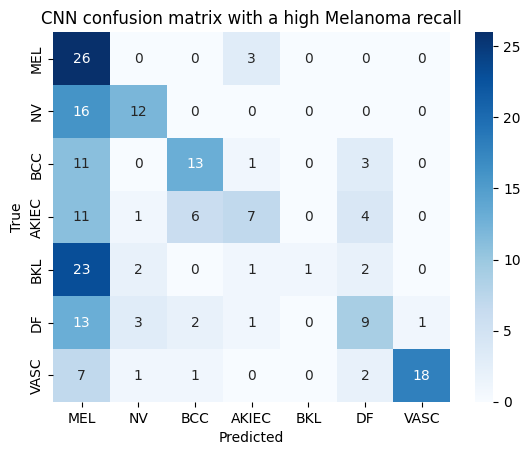

In [ ]:
y_true = np.argmax(y_val, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

category_names = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
# Confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('CNN confusion matrix with a high Melanoma recall')
plt.show()

Predicted probabilities: [0.35099155 0.01865778 0.25478908 0.2203325  0.0909155  0.06259354
 0.00172004]
Predicted class: 0, True class: 4


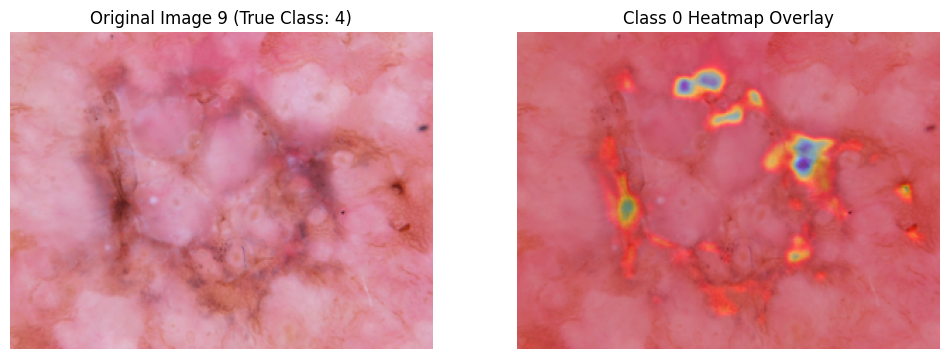

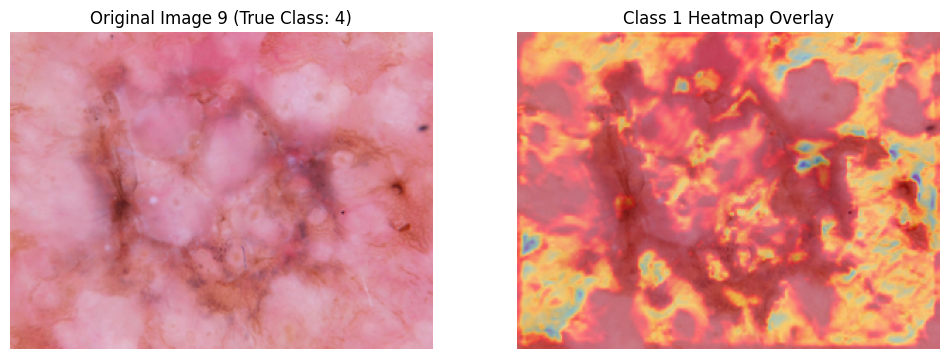

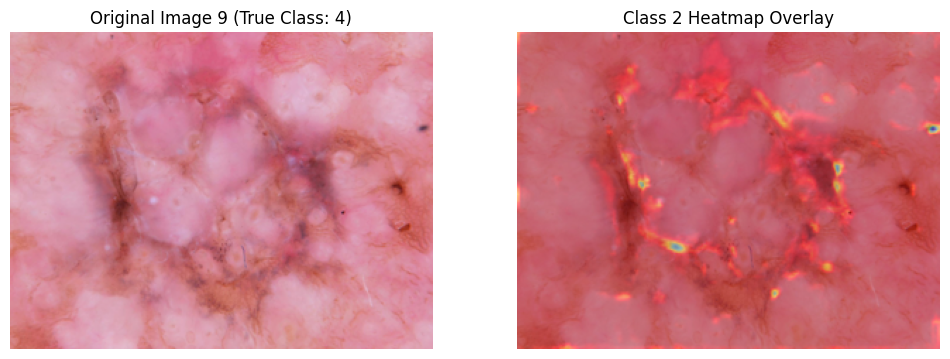

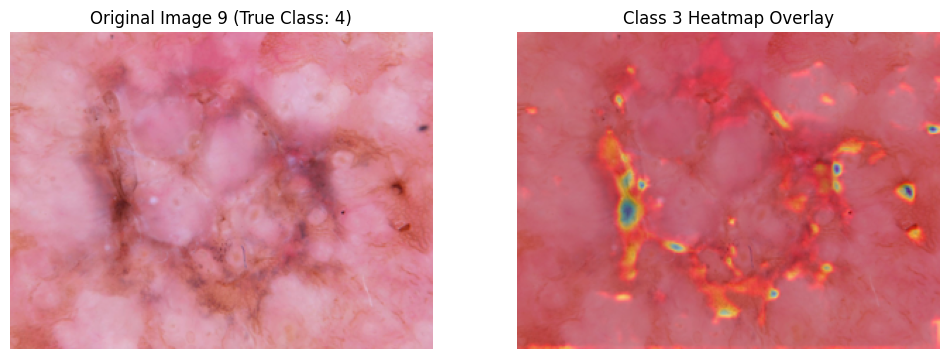

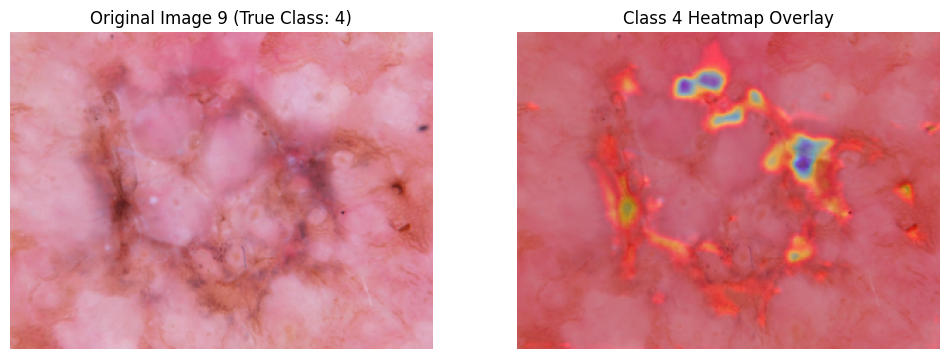

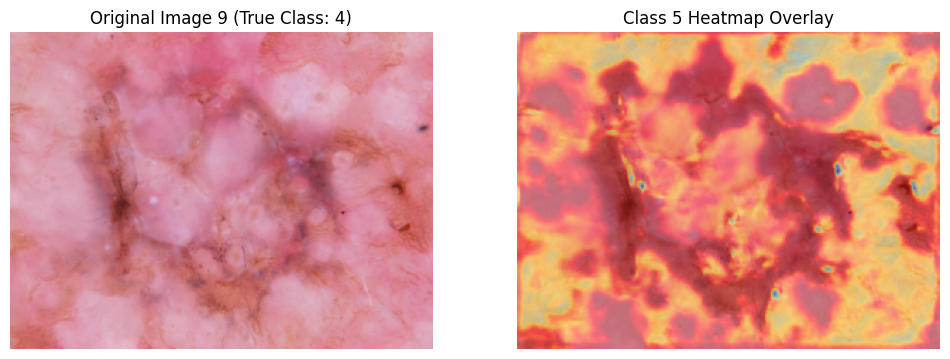

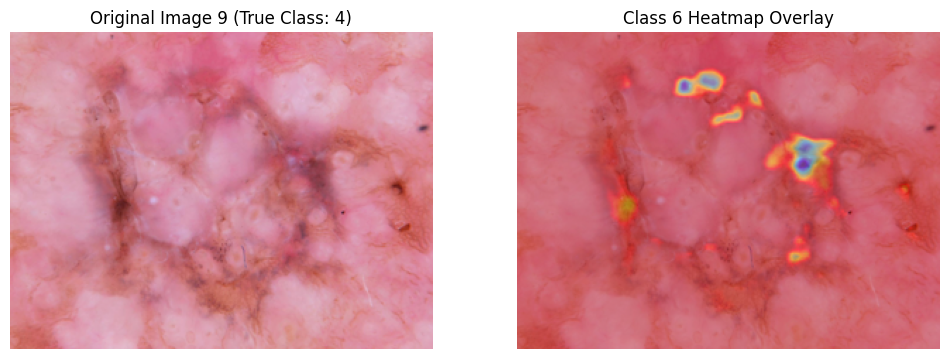

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.models import Model

# Based on the Keras offitial website: https://keras.io/examples/vision/grad_cam/
def grad_cam(model, image, class_idx, layer_name='conv2d_3'):
    # Get the last convolutional layer
    last_conv_layer = model.get_layer(layer_name)
    last_conv_layer_model = Model(model.inputs, last_conv_layer.output)

    # Get the classifier part of the model
    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer in model.layers[model.layers.index(last_conv_layer) + 1:]:
        x = layer(x)
    classifier_model = Model(classifier_input, x)

    # Get the gradient of the specified class with respect to the output feature map of last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output = last_conv_layer_model(np.array([image]))
        tape.watch(last_conv_layer_output)
        preds = classifier_model(last_conv_layer_output)
        class_channel = preds[:, class_idx]

    # This is the gradient of the specified class with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array by 'how important this channel is' with regard to the specified class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

    return heatmap

# Overlay the heatmap on original image
def overlay_heatmap(heatmap, original_image, alpha=0.6):
    heatmap = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + original_image
    return superimposed_img / superimposed_img.max()

# Function to load an image by its name
def load_image(image_name, images_path):
    img_path = f'{images_path}/{image_name}.jpg'
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

i = 20  # Image index

predicted_probabilities = y_pred_probs[i]
predicted_class = y_pred[i]  # The class predicted by the model
true_class = y_true[i]  # The actual class of the image

# Display predicted probabilities, predicted class, and true class
print(f'Predicted probabilities: {predicted_probabilities}')
print(f'Predicted class: {predicted_class}, True class: {true_class}')

for j in range(7):  # Assuming there are 7 classes
    # Generate heatmap for each class
    heatmap = grad_cam(model, images[i], j)

    # Overlay heatmap on original image
    superimposed_img = overlay_heatmap(heatmap, images[i], alpha=0.6)

    # Display original image and heatmap side by side
    plt.figure(figsize=(12, 6))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(images[i])
    plt.title(f'Original Image {i+1} (True Class: {true_class})')
    plt.axis('off')

    # Heatmap
    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title(f'Class {j} Heatmap Overlay')
    plt.axis('off')

    plt.show()


1/1 [==============================] - 0s 145ms/step


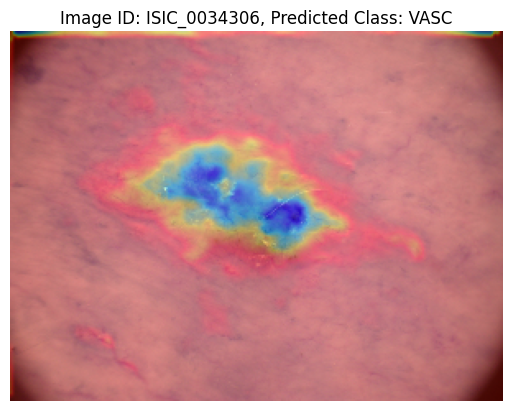

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt

# Based on the Keras offitial website: https://keras.io/examples/vision/grad_cam/
def grad_cam(model, image, class_idx, layer_name='conv2d_3'):
    # Get the last convolutional layer
    last_conv_layer = model.get_layer(layer_name)
    last_conv_layer_model = Model(model.inputs, last_conv_layer.output)

    # Get the classifier part of the model
    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer in model.layers[model.layers.index(last_conv_layer) + 1:]:
        x = layer(x)
    classifier_model = Model(classifier_input, x)

    # Get the gradient of the specified class with respect to the output feature map of last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output = last_conv_layer_model(np.array([image]))
        tape.watch(last_conv_layer_output)
        preds = classifier_model(last_conv_layer_output)
        class_channel = preds[:, class_idx]

    # This is the gradient of the specified class with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array by 'how important this channel is' with regard to the specified class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

    return heatmap

# Overlay the heatmap on original image
def overlay_heatmap(heatmap, original_image, alpha=0.4):
    heatmap = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + original_image * (1 - alpha)

    # Normalize the image
    superimposed_img = superimposed_img - superimposed_img.min()  # Shift the minimum value to 0.0
    superimposed_img = superimposed_img / superimposed_img.max()  # Scale the maximum value to 1.0

    return superimposed_img

# Function to load and preprocess an image
def load_image(image_name, images_path):
    img_path = f'{images_path}/{image_name}.jpg'
    img = image.load_img(img_path, target_size=(225, 300, 3))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img[0]

image_id = 'ISIC_0034306'  # Image ID
real_images_path = os.path.join(folder_path, "data/images")
img = load_image(image_id, real_images_path)  # Load and preprocess the image

predicted_probabilities = model.predict(np.expand_dims(img, axis=0))[0]
predicted_class = np.argmax(predicted_probabilities)

# Generate heatmap for the predicted class
heatmap = grad_cam(model, img, predicted_class)

# Overlay heatmap on original image
superimposed_img = overlay_heatmap(heatmap, img, alpha=0.4)

# Heatmap
category_names = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
plt.imshow(superimposed_img)
plt.title(f'Image ID: {image_id}, Predicted Class: {category_names[predicted_class]}')
plt.axis('off')

plt.show()